Имеются данные adult.csv (см. в материалах к занятию или на гитхабе).
Целевой переменной является уровень дохода income (крайний правый столбец).
Описание признаков можно найти по ссылке http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html

Вам необходимо построить модель логистической регрессии, которая предсказывает уровень дохода человека. При возможности попробуйте улучшить точность предсказаний (метод score) с помощью перебора признаков.

Готовый ноутбук выложить на гитхаб и прислать ссылку.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

/home/pavel/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('adult.csv')
print(df.shape)

(48842, 15)


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                48842 non-null int64
workclass          48842 non-null object
fnlwgt             48842 non-null int64
education          48842 non-null object
educational-num    48842 non-null int64
marital-status     48842 non-null object
occupation         48842 non-null object
relationship       48842 non-null object
race               48842 non-null object
gender             48842 non-null object
capital-gain       48842 non-null int64
capital-loss       48842 non-null int64
hours-per-week     48842 non-null int64
native-country     48842 non-null object
income             48842 non-null object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [4]:
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


In [5]:
df.income.value_counts()

<=50K    37155
>50K     11687
Name: income, dtype: int64

In [6]:
df.describe()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
df.mode()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,36,Private,203488,HS-grad,9,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,<=50K


In [8]:
col = [] 
for x in df.columns:
      if df[x].dtype == 'object':
             col.append(x)

In [9]:
col.remove('income')

In [10]:
col

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'native-country']

In [11]:
def get_woe_v1(df_train, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    #df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train

In [12]:
df['income'] = df['income'].str.replace('<=50K', '0')

In [13]:
df['income'] = df['income'].str.replace('>50K', '1')

In [14]:
df.income = df.income.astype('int')

In [15]:
target = 'income'

In [16]:
for col_get_prob in col:
    get_woe_v1(df, col_get_prob, target)

In [17]:
df.shape

(48842, 23)

In [18]:
correct_cols = []
for x in df.columns.tolist():
    if x not in col:
        correct_cols.append(x)

In [19]:
df = df[correct_cols]

In [20]:
df = df.fillna(0)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
age                   48842 non-null int64
fnlwgt                48842 non-null int64
educational-num       48842 non-null int64
capital-gain          48842 non-null int64
capital-loss          48842 non-null int64
hours-per-week        48842 non-null int64
income                48842 non-null int64
workclass_woe         48842 non-null float64
education_woe         48842 non-null float64
marital-status_woe    48842 non-null float64
occupation_woe        48842 non-null float64
relationship_woe      48842 non-null float64
race_woe              48842 non-null float64
gender_woe            48842 non-null float64
native-country_woe    48842 non-null float64
dtypes: float64(8), int64(7)
memory usage: 5.6 MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a5cd63550>,
      dtype=object)

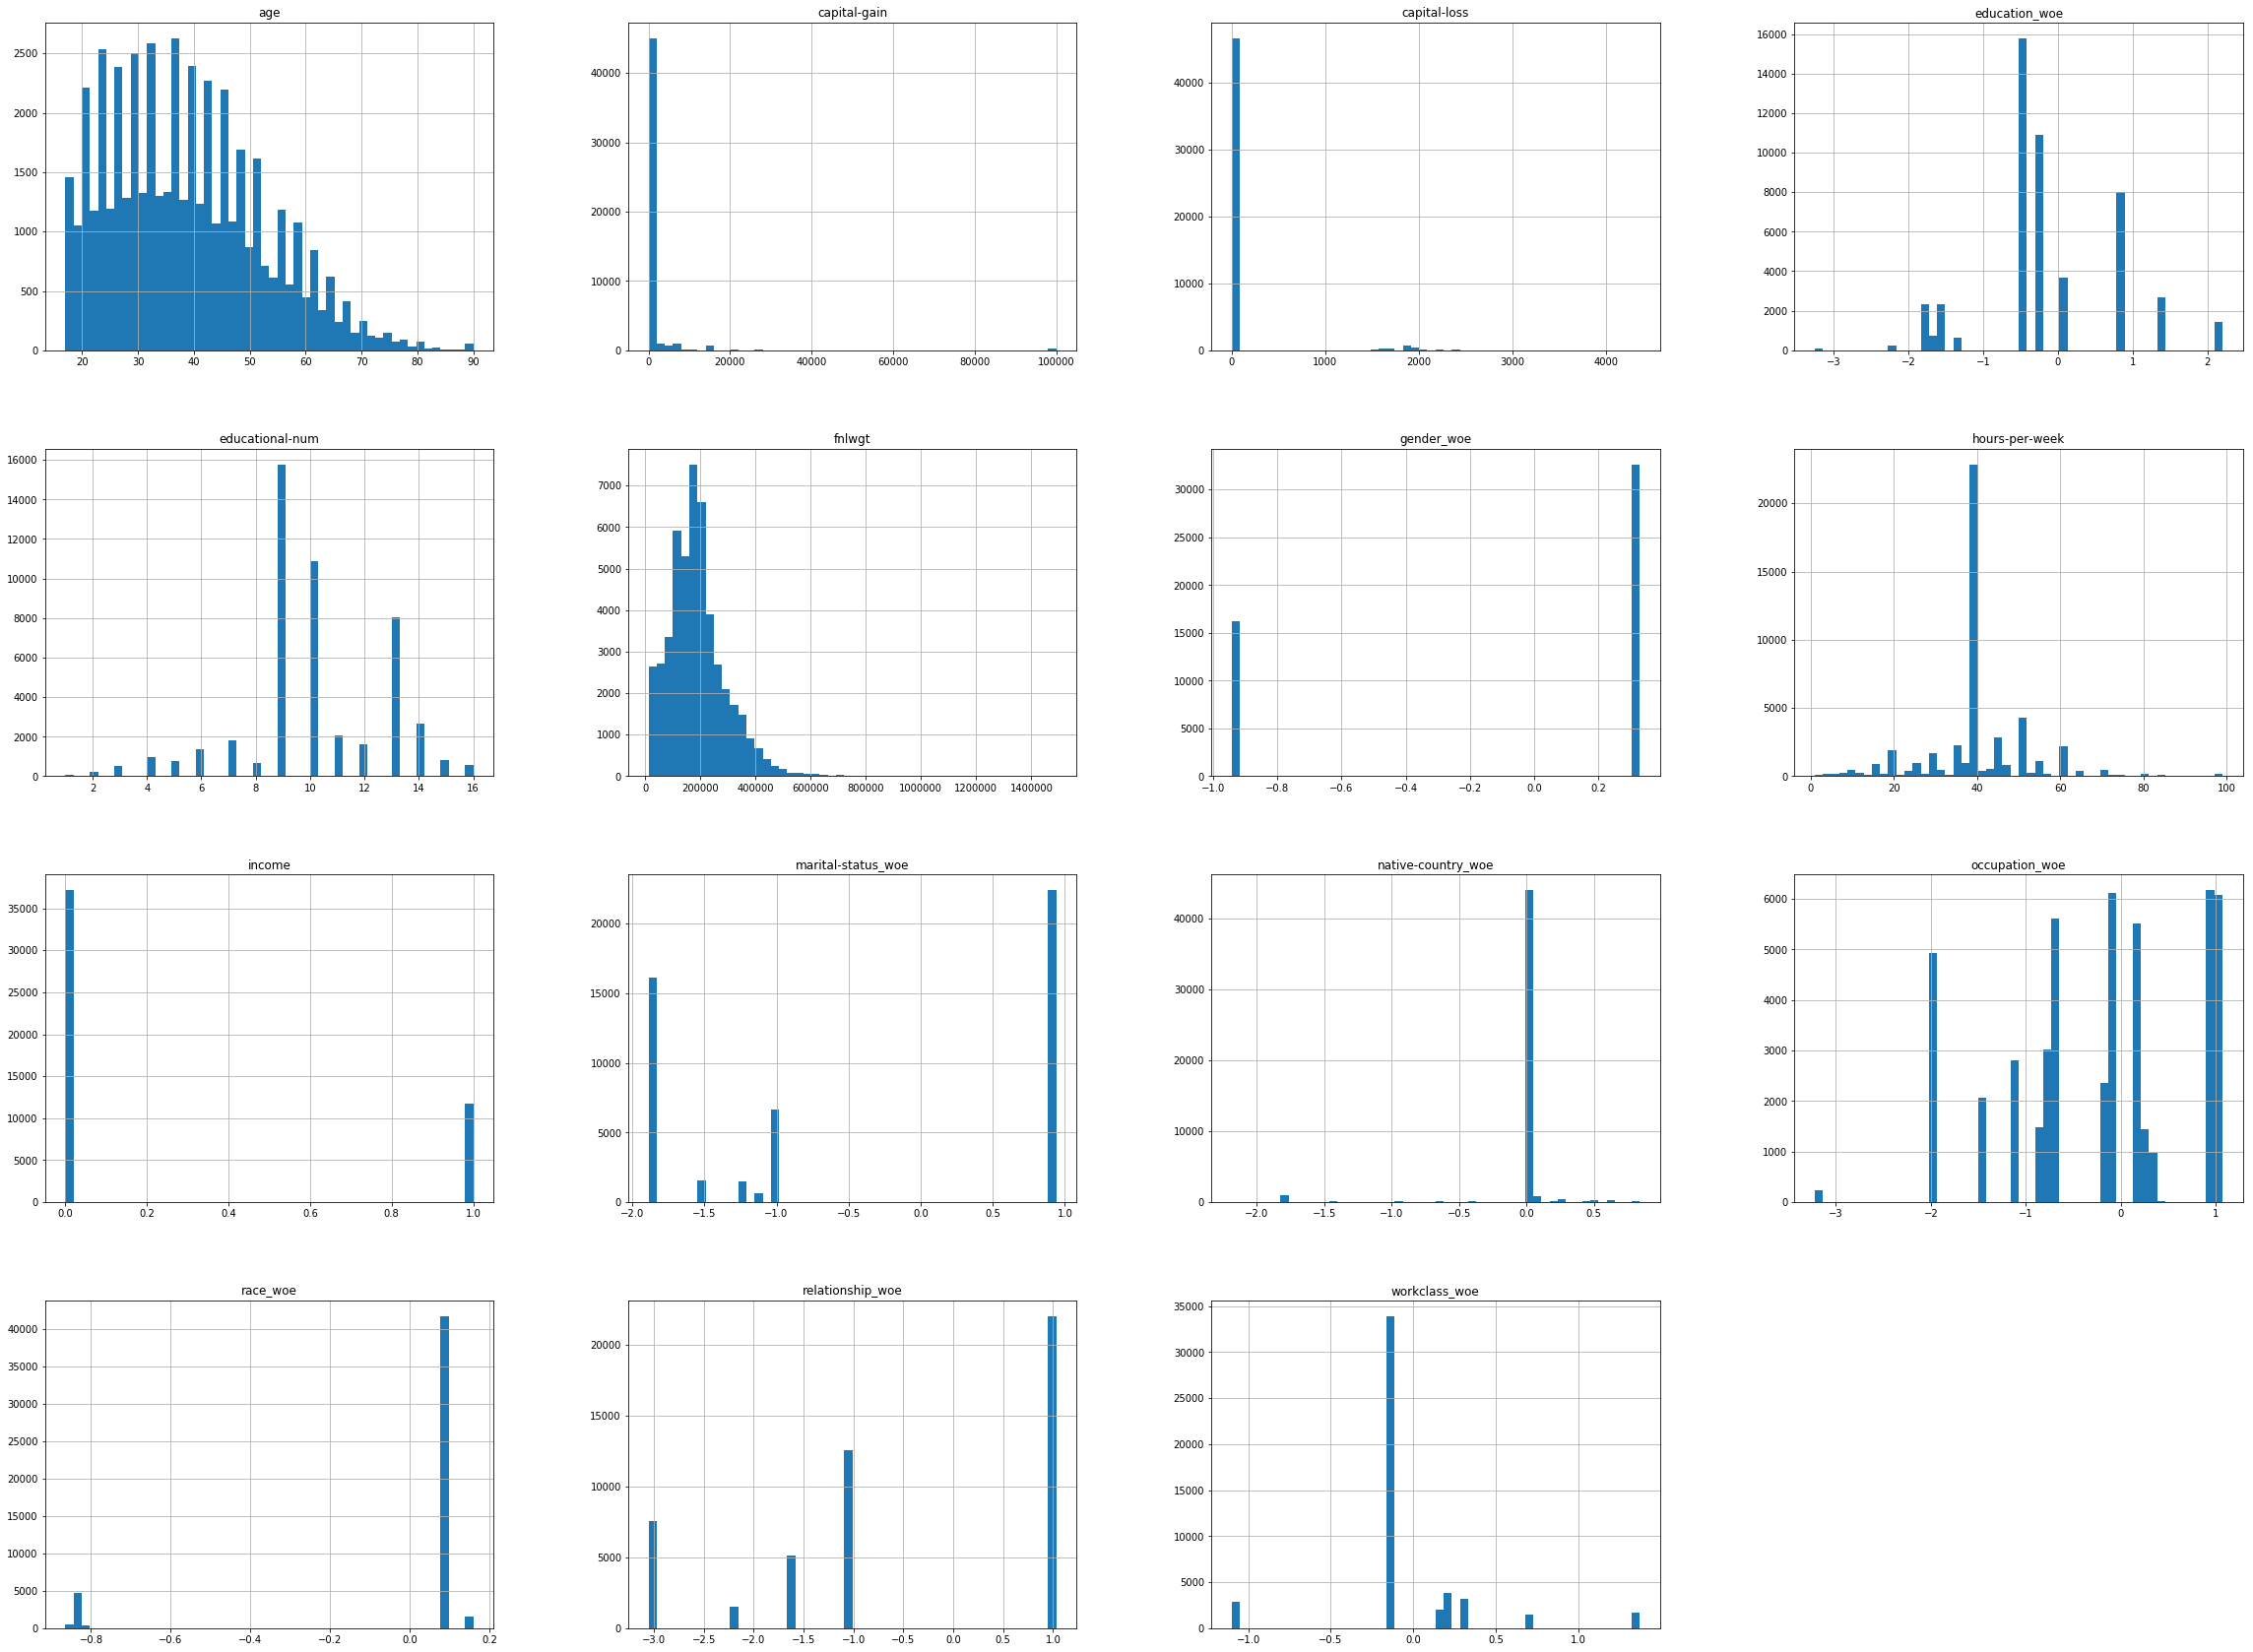

In [22]:
df.hist(bins=50, figsize=(40,30))

In [23]:
corr_matrix = df.corr()
corr =  corr_matrix[target].sort_values(ascending=False) 
corr

income                1.000000
marital-status_woe    0.444793
relationship_woe      0.434216
education_woe         0.353173
occupation_woe        0.336934
educational-num       0.332613
age                   0.230369
hours-per-week        0.227687
capital-gain          0.223013
gender_woe            0.214628
workclass_woe         0.176963
capital-loss          0.147554
race_woe              0.099845
native-country_woe    0.093759
fnlwgt               -0.006339
Name: income, dtype: float64

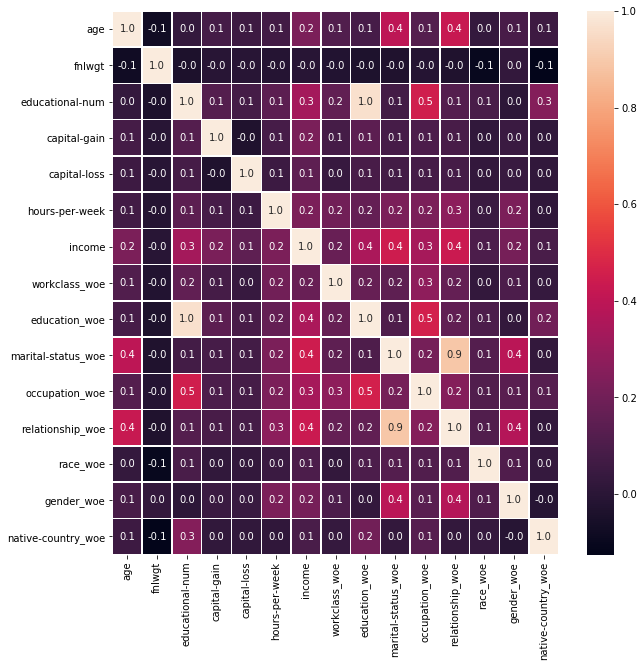

In [24]:
corr = df.corr()
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [25]:
y = df.income
X = df.drop('income', axis = 1)

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [28]:
num_folds = 5
seed = 7

In [29]:
kfold = KFold(n_splits=num_folds, random_state=seed)

In [30]:
LogReg = LogisticRegression()
results = cross_val_score(LogReg, X, y, cv=kfold)
print("Accuracy: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0
))

Accuracy: 84.853% (0.091%)


In [31]:
test_size = 0.2
seed = 7
model = LogReg
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_size,
random_state=seed)
model.fit(X_train, Y_train)
predicted = model.predict(X_test)
report = classification_report(Y_test, predicted)
print(report)

             precision    recall  f1-score   support

          0       0.87      0.93      0.90      7459
          1       0.71      0.57      0.63      2310

avg / total       0.84      0.84      0.84      9769



In [32]:
# Оценка по score модели
model.score(X_test, Y_test)

0.8442010441191524